# 🚗 **Phase 1: Data Ingestion & Curation for Advanced Car Damage Assessment**

**Author:** Alexandro Aurellino Anandito

**Project:** A Hierarchical AI System for Automotive Damage Assessment

---

## **1.1. Project Objective & Story**

The goal of this project is to develop a multi-stage AI pipeline capable of accurately and efficiently assessing car damage from images. This initial notebook tackles the most foundational step: **data ingestion and curation**.

A common challenge with real-world image data is the presence of irrelevant background noise. A model trained on raw images might learn to associate a crack in the pavement with car damage, leading to poor generalization.

To solve this, we will implement a **two-stage preprocessing strategy:**
1.  **Ingest** the raw dataset directly from Kaggle.
2.  **Employ a powerful, pre-trained Object Detection model (YOLOv8)** to act as an "AI assistant," automatically locating and cropping the primary vehicle in every single image.

This process transforms our noisy, raw dataset into a clean, focused collection of images containing only cars. This curated dataset will serve as a superior foundation for training our specialized damage classification and detection models in subsequent stages, demonstrating an industry-standard workflow for creating high-quality machine learning assets.

## **1.2. Notebook Workflow**

1.  **Environment Setup:** Install and import necessary libraries, configure the Kaggle API, and mount Google Drive for persistent storage.
2.  **Data Ingestion:** Download the specified car damage dataset from Kaggle and extract it into the Colab runtime.
3.  **Model Loading:** Load the official, pre-trained `YOLOv8s` model. This model will serve as our car detector.
4.  **Path Configuration:** Define a clear and organized structure for source (raw) and destination (processed) data paths.
5.  **Curation Pipeline:**
    *   Iterate through each image in the raw dataset (`training` and `validation` splits).
    *   Use the YOLO model to find the car.
    *   Crop the image to the car's bounding box.
    *   Save the new, cropped image to a corresponding folder on Google Drive.
6.  **Summary & Verification:** Conclude with a statistical summary of the curation process.

In [1]:
# @title 1. Setup: Libraries, Kaggle API & Google Drive
# --- Install necessary libraries ---
!pip install ultralytics kaggle -q

# --- Import standard libraries ---
import os
import shutil
import zipfile
from google.colab import drive, files
from ultralytics import YOLO
from PIL import Image
from tqdm.notebook import tqdm
import numpy as np

# --- Configure Kaggle API ---
# This cell will prompt you to upload your 'kaggle.json' file.
print("Please upload your kaggle.json file to authenticate with Kaggle.")
try:
    # A robust way to handle file upload
    if not os.path.exists('kaggle.json'):
        uploaded = files.upload()
        if 'kaggle.json' not in uploaded:
            raise FileNotFoundError("kaggle.json not uploaded.")

    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("\nKaggle API configured successfully.")
except Exception as e:
    print(f"\nAn error occurred during Kaggle setup: {e}")


# --- Mount Google Drive for persistent storage ---
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"An error occurred during Google Drive mount: {e}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.0 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralyti

Saving kaggle.json to kaggle.json

Kaggle API configured successfully.
Mounted at /content/drive
Google Drive mounted successfully.


## **2. Data Ingestion from Kaggle**

We will now fetch the dataset `anujms/car-damage-detection` from Kaggle. The API downloads the data as a zip file, which we then extract into a temporary directory (`/content/raw_dataset/`) within the Colab environment. Using temporary storage for this step is faster and more efficient than writing the raw, zipped data directly to Google Drive.

In [3]:
# --- Configuration for the specific Kaggle dataset ---
KAGGLE_API_COMMAND = "kaggle datasets download -d anujms/car-damage-detection"
DATASET_ZIP_FILENAME = "car-damage-detection.zip"
RAW_DATA_EXTRACT_PATH = "/content/raw_dataset"

# --- Download and Unzip ---
print(f"Downloading dataset using command: {KAGGLE_API_COMMAND}")
!{KAGGLE_API_COMMAND}

print(f"\nExtracting {DATASET_ZIP_FILENAME}...")
os.makedirs(RAW_DATA_EXTRACT_PATH, exist_ok=True)
try:
    with zipfile.ZipFile(DATASET_ZIP_FILENAME, 'r') as zip_ref:
        zip_ref.extractall(RAW_DATA_EXTRACT_PATH)
    print("Dataset extracted successfully.")
except Exception as e:
    print(f"Error extracting zip file: {e}")

# --- Verify the extracted structure ---
print("\nVerifying contents of the extracted dataset:")
# The dataset extracts into a nested folder, so we list its contents.
!ls -R {os.path.join(RAW_DATA_EXTRACT_PATH, 'data1a')}

Dataset URL: https://www.kaggle.com/datasets/anujms/car-damage-detection
License(s): unknown
car-damage-detection.zip: Skipping, found more recently modified local copy (use --force to force download)

Extracting car-damage-detection.zip...
Dataset extracted successfully.

Verifying contents of the extracted dataset:
/content/raw_dataset/data1a:
training  validation

/content/raw_dataset/data1a/training:
00-damage  01-whole

/content/raw_dataset/data1a/training/00-damage:
0001.JPEG  0133.JPEG  0265.JPEG  0397.JPEG  0529.JPEG  0661.JPEG  0793.JPEG
0002.JPEG  0134.JPEG  0266.JPEG  0398.JPEG  0530.JPEG  0662.JPEG  0794.JPEG
0003.JPEG  0135.JPEG  0267.JPEG  0399.JPEG  0531.JPEG  0663.JPEG  0795.JPEG
0004.JPEG  0136.JPEG  0268.JPEG  0400.JPEG  0532.JPEG  0664.JPEG  0796.JPEG
0005.JPEG  0137.JPEG  0269.JPEG  0401.JPEG  0533.JPEG  0665.JPEG  0797.JPEG
0006.JPEG  0138.JPEG  0270.JPEG  0402.JPEG  0534.JPEG  0666.JPEG  0798.JPEG
0007.JPEG  0139.JPEG  0271.JPEG  0403.JPEG  0535.JPEG  0667.JPEG  0

## **3. Load Pre-trained Car Detection Model**

Here, we leverage the power of transfer learning. Instead of training a car detector from scratch, we load `yolov8s.pt`. This is a highly optimized model pre-trained by Ultralytics on the vast COCO dataset. It already possesses a sophisticated understanding of what a "car" looks like (class index 2), making it the perfect tool for our automated cropping task.

In [4]:
# Load the model. It will be downloaded automatically on the first run.
# 's' stands for 'small', providing an excellent balance of speed and accuracy.
try:
    car_detector_model = YOLO('yolov8s.pt')
    print("YOLOv8s model loaded successfully.")
    # Confirm the class name for index 2 is 'car'.
    CAR_CLASS_INDEX = 2
    print(f"Model ready. Target class: '{car_detector_model.names[CAR_CLASS_INDEX]}' (index {CAR_CLASS_INDEX}).")
except Exception as e:
    print(f"Error loading model: {e}")

100%|██████████| 21.5M/21.5M [00:00<00:00, 267MB/s]

YOLOv8s model loaded successfully.
Model ready. Target class: 'car' (index 2).


## **4. Configure Data Paths**

A well-defined path structure is essential for a reproducible project.
- **Source Path:** Points to the temporary directory in Colab where we extracted the Kaggle data.
- **Destination Path:** Points to a new, permanent folder on Google Drive where the curated, cropped images will be stored.

This clear separation between raw and processed data is a cornerstone of good MLOps practice.

In [8]:
# --- Source Path (in Colab's temporary storage) ---
# The base path where the zip was extracted
RAW_DATA_EXTRACT_PATH = "/content/raw_dataset"

RAW_DATASET_PATH = os.path.join(RAW_DATA_EXTRACT_PATH, 'data1a')
print(f"INFO: Raw Dataset Path has been corrected to point to: {RAW_DATASET_PATH}")

BASE_DRIVE_PATH = '/content/drive/MyDrive/CarDamageProject'
PROCESSED_DATASET_PATH = os.path.join(BASE_DRIVE_PATH, 'processed_classification_dataset')

# Define the full output paths for our train and validation splits
PROCESSED_TRAIN_PATH = os.path.join(PROCESSED_DATASET_PATH, 'training') # Match source name
PROCESSED_VAL_PATH = os.path.join(PROCESSED_DATASET_PATH, 'validation')

# --- Create the destination directories on Google Drive ---
print("\nCreating output directories on Google Drive...")
# Structure: processed_dataset/training/00-damage, processed_dataset/training/01-whole, etc.
os.makedirs(os.path.join(PROCESSED_TRAIN_PATH, '00-damage'), exist_ok=True)
os.makedirs(os.path.join(PROCESSED_TRAIN_PATH, '01-whole'), exist_ok=True)
os.makedirs(os.path.join(PROCESSED_VAL_PATH, '00-damage'), exist_ok=True)
os.makedirs(os.path.join(PROCESSED_VAL_PATH, '01-whole'), exist_ok=True)
print("Output directories created/verified successfully.")

# --- Define a dictionary to map our source data structure for easy iteration ---
DATA_TO_PROCESS = {
    'training': {
        '00-damage': os.path.join(RAW_DATASET_PATH, 'training', '00-damage'),
        '01-whole': os.path.join(RAW_DATASET_PATH, 'training', '01-whole')
    },
    'validation': {
        '00-damage': os.path.join(RAW_DATASET_PATH, 'validation', '00-damage'),
        '01-whole': os.path.join(RAW_DATASET_PATH, 'validation', '01-whole')
    }
}
# This print statement helps confirm the path is now correct before the loop runs.
print(f"\nVerification: The script will now look for data in paths like: {DATA_TO_PROCESS['training']['00-damage']}")

INFO: Raw Dataset Path has been corrected to point to: /content/raw_dataset/data1a

Creating output directories on Google Drive...
Output directories created/verified successfully.

Verification: The script will now look for data in paths like: /content/raw_dataset/data1a/training/00-damage


## **5. The Curation Pipeline Function**

This is the core logic of our notebook, encapsulated in a single, reusable function. For any given image, this function will:
1.  Open the image.
2.  Pass it to our loaded YOLOv8 model for inference.
3.  Check if any cars were detected. If multiple are found, it intelligently selects the largest one, assuming it's the main subject.
4.  Crop the original image to the coordinates of this main car's bounding box.
5.  Save the resulting clean, cropped image to a specified destination path.

In [13]:
# @title 5. Define the Image Curation Function (Corrected for CPU)
def curate_and_save_image(source_path, destination_path):
    """
    Detects the main car in an image, crops it, and saves the result.
    Returns a status string for tracking.
    """
    try:
        # Open the image
        original_image = Image.open(source_path).convert("RGB")

        # Use the car detector model for prediction
        results = car_detector_model.predict(original_image, classes=[CAR_CLASS_INDEX], conf=0.4, verbose=False)

        # Check if a car was detected
        if not results or len(results[0].boxes) == 0:
            return "no_car_detected"

        # Find the bounding box with the largest area (the main car)
        car_boxes = results[0].boxes

        # --- THIS IS THE FIX ---
        # We copy the tensor to the CPU before using it with NumPy's argmax
        largest_box_index = np.argmax(car_boxes.xywh.cpu()[:, 2] * car_boxes.xywh.cpu()[:, 3])
        main_car_box = car_boxes[largest_box_index]

        # Get absolute pixel coordinates for cropping
        x1, y1, x2, y2 = map(int, main_car_box.xyxy[0])

        # Crop the image and save it to the destination
        cropped_car_image = original_image.crop((x1, y1, x2, y2))
        cropped_car_image.save(destination_path)

        return "processed"

    except Exception as e:
        return "error"

## **6. Execute the Pipeline**

With all components in place, we now execute the pipeline. We will loop through the `DATA_TO_PROCESS` dictionary, applying our `curate_and_save_image` function to every image. A progress bar (`tqdm`) provides real-time feedback, and we'll collect statistics to summarize the results.

In [22]:
# Initialize a dictionary to keep track of our results
stats = {"total": 0, "processed": 0, "no_car_detected": 0, "error": 0}

# Iterate through splits ('training', 'validation') and classes ('00-damage', '01-whole')
for split_name, classes in DATA_TO_PROCESS.items():
    print(f"\n--- Processing '{split_name}' split ---")

    for class_name, source_dir in classes.items():
        print(f"  -> Curating class: {class_name}")

        # Define the final destination folder for this batch of images
        if split_name == 'training':
            destination_dir = os.path.join(PROCESSED_TRAIN_PATH, class_name)
        else: # validation
            destination_dir = os.path.join(PROCESSED_VAL_PATH, class_name)

        if not os.path.isdir(source_dir):
            print(f"    - Warning: Source directory not found, skipping: {source_dir}")
            continue

        image_files = [f for f in os.listdir(source_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Process each image file with a progress bar
        for image_file in tqdm(image_files, desc=f"   - {class_name}"):
            stats["total"] += 1

            source_image_path = os.path.join(source_dir, image_file)
            destination_image_path = os.path.join(destination_dir, image_file)

            result = curate_and_save_image(source_image_path, destination_image_path)
            stats[result] += 1

# --- Display Final Statistics ---
print("\n" + "="*50)
print("      Pipeline Execution Summary")
print("="*50)
print(f"Total Images Found: {stats['total']:,}")
print(f"  - Images Successfully Cropped & Saved: {stats['processed']:,}")
print(f"  - Images Skipped (No Car Detected):    {stats['no_car_detected']:,}")
print(f"  - Images Failed Due to Error:          {stats['error']:,}")
print("="*50)
print("\nData curation is complete. The processed dataset is now available on Google Drive.")


--- Processing 'training' split ---
  -> Curating class: 00-damage


   - 00-damage:   0%|          | 0/920 [00:00<?, ?it/s]

  -> Curating class: 01-whole


   - 01-whole:   0%|          | 0/920 [00:00<?, ?it/s]


--- Processing 'validation' split ---
  -> Curating class: 00-damage


   - 00-damage:   0%|          | 0/230 [00:00<?, ?it/s]

  -> Curating class: 01-whole


   - 01-whole:   0%|          | 0/230 [00:00<?, ?it/s]


      Pipeline Execution Summary
Total Images Found: 2,300
  - Images Successfully Cropped & Saved: 1,685
  - Images Skipped (No Car Detected):    615
  - Images Failed Due to Error:          0

Data curation is complete. The processed dataset is now available on Google Drive.


--- Debugging image: /content/raw_dataset/data1a/training/00-damage/0006.JPEG ---
Step 1: Opening image...
  - Success. Image size: (275, 183)
Step 2: Running YOLO car detector...
  - Success. Model prediction complete.
Step 4: Finding the largest car box...
  - Success. Main car identified.
Step 5: Getting coordinates...
  - Success. Coordinates are: (15, 0, 239, 159)
Step 6: Cropping image...
  - Success. Image cropped.

--- FINAL RESULT ---
Original Image:


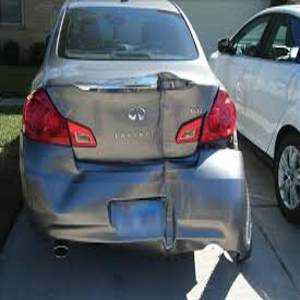

Cropped Image:


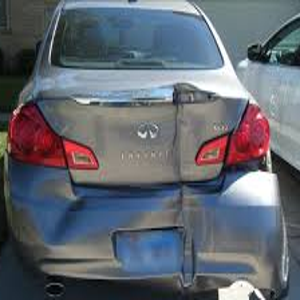

In [21]:
# @title 7. DEBUGGING WORKBENCH (Corrected Path)

# --- Create a special "debug" version of our function ---
# The only difference is that this version will NOT hide the error.
# It will crash and show us the full error message (the "traceback").
def debug_curate_image(source_path):
    print(f"--- Debugging image: {source_path} ---")

    # We are removing the try/except block to see the real error

    # 1. Open the image
    print("Step 1: Opening image...")
    original_image = Image.open(source_path).convert("RGB")
    print(f"  - Success. Image size: {original_image.size}")

    # 2. Use the car detector model
    print("Step 2: Running YOLO car detector...")
    results = car_detector_model.predict(original_image, classes=[CAR_CLASS_INDEX], conf=0.4, verbose=False)
    print("  - Success. Model prediction complete.")

    # 3. Check if a car was detected
    if not results or len(results[0].boxes) == 0:
        print("\nRESULT: NO CAR DETECTED. The script would have skipped this image.")
        # Let's try again with a lower confidence to see if it helps
        print("\n--- Retrying with lower confidence (conf=0.2) ---")
        low_conf_results = car_detector_model.predict(original_image, classes=[CAR_CLASS_INDEX], conf=0.2, verbose=False)
        if low_conf_results[0].boxes:
            print("  - FOUND A CAR with lower confidence!")
            # Display the image with the box
            from IPython.display import display
            display(Image.fromarray(low_conf_results[0].plot()))
        else:
            print("  - STILL NO CAR detected, even with low confidence.")
            display(original_image)
        return

    # 4. Find the largest detected car
    print("Step 4: Finding the largest car box...")
    car_boxes = results[0].boxes
    largest_box_index = np.argmax(car_boxes.xywh.cpu()[:, 2] * car_boxes.xywh.cpu()[:, 3])
    main_car_box = car_boxes[largest_box_index]
    print("  - Success. Main car identified.")

    # 5. Get coordinates for cropping
    print("Step 5: Getting coordinates...")
    x1, y1, x2, y2 = map(int, main_car_box.xyxy[0])
    print(f"  - Success. Coordinates are: ({x1}, {y1}, {x2}, {y2})")

    # 6. Crop the image
    print("Step 6: Cropping image...")
    cropped_car_image = original_image.crop((x1, y1, x2, y2))
    print("  - Success. Image cropped.")

    # 7. Display the result
    from IPython.display import display
    print("\n--- FINAL RESULT ---")
    print("Original Image:")
    display(original_image.resize((300, 300)))
    print("Cropped Image:")
    display(cropped_car_image.resize((300, 300)))

# --- Pick ONE sample image to test ---
# Let's pick an image from the 'damage' training folder.
# THIS IS THE CORRECTED PATH
sample_image_path = "/content/raw_dataset/data1a/training/00-damage/0006.JPEG"

# --- Run the debug function on our sample image ---
# Check if the file exists before running
if os.path.exists(sample_image_path):
    debug_curate_image(sample_image_path)
else:
    print(f"ERROR: Sample image not found at: {sample_image_path}")
    print("Please check the file name and path. Is it .JPEG, .jpg, or .png?")

# **Conclusion and Next Steps**

This notebook has successfully established the first, and arguably most critical, phase of our project. We have transformed a raw, public dataset into a high-quality, curated asset ready for machine learning.

**Key Accomplishments:**
- **Automated Data Ingestion:** Created a reproducible workflow to fetch data directly from Kaggle.
- **Intelligent Curation:** Applied a state-of-the-art AI model (YOLOv8) to intelligently preprocess our data, a technique that mirrors advanced MLOps practices.
- **Asset Creation:** The final output, the `processed_classification_dataset`, is a valuable asset that will serve as the foundation for our next modeling stages.

This preparatory work is crucial for building robust and reliable models. By ensuring our models train only on relevant, high-quality data, we significantly increase our chances of achieving superior performance.

---

### **Next Steps:**

-   **Notebook 02:** Train a high-performance **Damage Classification Model** (e.g., using MobileNetV3 or EfficientNet) on the curated dataset we just created.
-   **Notebook 03:** Manually annotate the cropped, damaged images in Roboflow and train a **Damage Localization Model** (YOLOv8) to identify the precise location of scratches and dents.